In [ ]:
import os
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
%matplotlib inline


df = pd.read_csv("/content/TrainingWiDS2021.csv")
df_cols = pd.read_csv("/content/DataDictionaryWiDS2021.csv")
df.drop(columns = 'Unnamed: 0', inplace = True)

# WiDS Datathon 2021

* https://www.kaggle.com/c/widsdatathon2021/data?select=TrainingWiDS2021.csv
* https://he.wikipedia.org/wiki/%D7%A1%D7%95%D7%9B%D7%A8%D7%AA
* https://www.health.gov.il/PublicationsFiles/diabetes_registry_report_2019.pdf

## Overview
This year's challenge will focus on models to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus. Using data from the first 24 hours of intensive care, individuals and teams will explore labeled training data for model development. Participants will then upload predictions for unlabeled data to Kaggle and these predictions will be used to determine the public leaderboard rankings, as well as the final leaderboard revealed at the close of the competition.

Data analysis can be completed using your preferred tools. Tutorials, sample code, and other resources will be posted throughout the competition at widsconference.org/datathon-resources and on the Kaggle Discussion Forum.

The WiDS Datathon 2021 dataset is similar to the WiDS Datathon 2020 dataset, but prior experience is not needed. This year's WiDS Datathon will also feature a Phase 2 hosted by the National Science Foundation Big Data Innovation Hubs, to encourage research papers and further collaboration. Special thanks to Kaggle for supporting the suite of WiDS Datathon cash awards this year, totaling $10,000 USD

## Evaluation
Submissions for the leaderboard will be evaluated on the Area under the Receiver Operating Characteristic (ROC) curve between the predicted and the observed target (diabetes_mellitus_diagnosis).

Learn more about AUC in this developer crash course, this video, or this Kaggle Learn Forum post.

Submission Format
For each encounter_id in the test dataset, you are asked to explore the columns of data (for example, patient laboratory results, demographics, and vital signs) and create a model that classifies whether the ICU patient has been diagnosed with Diabetes Mellitus.

A diabetes_mellitus value of 1 corresponds to a positive diagnosis (i.e., the patient has been diagnosed to have Diabetes Mellitus) and a value of 0 corresponds to a negative diagnosis.

# EDA

In [ ]:
df_diabetes = pd.read_csv('TrainingWiDS2021.csv', index_col=0)
df_diabetes.reset_index(drop=True, inplace=True)
df_dic = pd.read_csv('DataDictionaryWiDS2021.csv')
print(f'train shape: {df_diabetes.shape}, dict shape: {df_dic.shape}')

train shape: (130157, 180), dict shape: (181, 6)


## cleaning/fixing the data and feature selection

In [ ]:
def data_cleaning(threshold = 0.2):

    # fix bmi column
    df_diabetes['bmi'] = round(10000 * df_diabetes['weight'] / (df_diabetes['height'] ** 2), 8)
    mask_lst= []
    for i in range(len(df_diabetes)):
        mask_lst.append(round(10000*df_diabetes.weight[i] / (df_diabetes.height[i]**2), str(df_diabetes.bmi[i])[::-1].find('.')) == df_diabetes.bmi[i])

    # drop columns with more na values than threshold 
    threshold = threshold
    col_to_be_drop = (df_diabetes.isnull().sum() / df_diabetes.shape[0] <= threshold) \
    [~(df_diabetes.isnull().sum() / df_diabetes.shape[0] <= threshold)].index
    print(f'number of columns to drop: {len(col_to_be_drop)}')
    df_diabetes.drop(columns=col_to_be_drop, inplace=True)
    print(f'train shape: {df_diabetes.shape}')
    
        # look at
    look_at_lst = ['d1_hco3_max', 'd1_hco3_max',  'd1_platelets_min', 'd1_platelets_max',  'd1_calcium_max',
     'd1_calcium_min', 'd1_hemaglobin_max','d1_hemaglobin_min','d1_potassium_min', 'h1_diasbp_noninvasive_min','h1_diasbp_noninvasive_max','h1_sysbp_noninvasive_min',
     'h1_sysbp_noninvasive_max','h1_spo2_max','h1_spo2_min', 'pre_icu_los_days']
    fintuning_drop = ['bun_apache','creatinine_apache','sodium_apache', 'd1_wbc_max','d1_wbc_min','d1_hematocrit_max',
     'd1_hematocrit_min','h1_mbp_noninvasive_min','h1_mbp_noninvasive_max','d1_creatinine_min',
     'd1_creatinine_max','d1_sodium_min','d1_sodium_max','temp_apache','h1_mbp_min','h1_mbp_max',
     'h1_resprate_max','h1_resprate_min','h1_diasbp_max','h1_diasbp_min','h1_sysbp_min','h1_sysbp_max','d1_temp_min',
     'd1_temp_max','h1_heartrate_max','h1_heartrate_min','weight','d1_mbp_noninvasive_min','d1_mbp_noninvasive_max','gcs_motor_apache',
     'gcs_eyes_apache','gcs_verbal_apache','height','d1_diasbp_noninvasive_min','d1_diasbp_noninvasive_max',
     'd1_sysbp_noninvasive_min','d1_sysbp_noninvasive_max','apache_3j_diagnosis','resprate_apache','gcs_unable_apache',
     'd1_resprate_min','d1_resprate_max','d1_spo2_min','d1_spo2_max','map_apache','d1_mbp_max','d1_mbp_min',
     'heart_rate_apache','d1_diasbp_max','d1_diasbp_min','d1_sysbp_min','d1_sysbp_max','d1_heartrate_max','d1_heartrate_min',
     'icu_admit_source','aids','cirrhosis','hepatic_failure','immunosuppression',
     'leukemia','lymphoma','solid_tumor_with_metastasis','encounter_id','hospital_id','ventilated_apache','intubated_apache',
     'arf_apache','apache_post_operative','readmission_status','icu_stay_type','icu_id','elective_surgery','glucose_apache','d1_hco3_min']
    fintuning_drop = fintuning_drop + look_at_lst

    #stay
    stay_lst = ['d1_glucose_max','d1_glucose_min','age','bmi','apache_2_diagnosis', 'ethnicity', 'gender',
     'icu_type', 'diabetes_mellitus', 'd1_bun_max',  'd1_potassium_max']
    
    print(f'number of columns to drop: {len(fintuning_drop)}')
    df_diabetes.drop(columns=fintuning_drop, inplace=True)
    print(f'train shape: {df_diabetes.shape}')
    print(df_diabetes.shape)
    df_diabetes.loc[df_diabetes.ethnicity.isnull(),'ethnicity'] = 'Other/Unknown'
    df_diabetes.dropna(inplace=True)
    print(df_diabetes.shape)
    
    # replace values where min > max
    glucos_min = df_diabetes[df_diabetes['d1_glucose_max'] < df_diabetes['d1_glucose_min']]['d1_glucose_min'].values[0]
    glucose_index = df_diabetes[df_diabetes['d1_glucose_max'] < df_diabetes['d1_glucose_min']]['d1_glucose_min'].index
    glucos_max = df_diabetes.loc[glucose_index, 'd1_glucose_max'].values[0]
    df_diabetes.loc[glucose_index, 'd1_glucose_min'] = glucos_max
    df_diabetes.loc[glucose_index, 'd1_glucose_max'] = glucos_min
    
    bun_min = df_diabetes[df_diabetes['d1_bun_max'] < df_diabetes['d1_bun_min']]['d1_bun_min'].values
    bun_index = df_diabetes[df_diabetes['d1_bun_max'] < df_diabetes['d1_bun_min']]['d1_bun_min'].index
    bun_max = df_diabetes.loc[bun_index, 'd1_bun_max'].values
#     print(bun_min)
#     print(bun_index)
#     print(bun_max)
    df_diabetes.loc[bun_index, 'd1_bun_min'] = bun_max
    df_diabetes.loc[bun_index, 'd1_bun_max'] = bun_min

In [ ]:
data_cleaning()

number of columns to drop: 79
train shape: (130157, 101)
number of columns to drop: 90
train shape: (130157, 12)
(130157, 12)
(106667, 12)


In [ ]:
def data_cleaning_outliers(df_diabetes):
    print(df_diabetes.shape)
    # removing age = 0.0 
    df_diabetes = df_diabetes[~(df_diabetes['age']==0)]
    # claening with Z value
    numeric_col = list(df_diabetes.select_dtypes(include=['float64', 'int64']).columns)
    numeric_col.remove('apache_2_diagnosis')
    numeric_col.remove('age')
    numeric_col.remove('diabetes_mellitus')
    df_diabetes = df_diabetes[(np.abs(sc.stats.zscore(df_diabetes[numeric_col])) < 3).all(axis=1)]

    # another option of cleaning is with IQR value
    # Q1 = df_diabetes[numeric_col_remove_from].quantile(0.25)
    # Q3 = df_diabetes[numeric_col_remove_from].quantile(0.75)
    # IQR = Q3 - Q1
    # len(df_diabetes) - len(df_diabetes[((df_diabetes[numeric_col_remove_from] >= (Q1 - 1.5 * IQR)) & (df_diabetes[numeric_col_remove_from] <= (Q3 + 1.5 * IQR))).all(axis=1)])

    print(df_diabetes.shape)
    return df_diabetes.copy()

In [ ]:
df_diabetes = data_cleaning_outliers(df_diabetes)
df_diabetes.head()

(106667, 12)
(97117, 12)


,age,bmi,ethnicity,gender,icu_type,apache_2_diagnosis,d1_bun_max,d1_bun_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,diabetes_mellitus
0,68.0,22.732803,Caucasian,M,CTICU,113.0,31.0,30.0,168.0,109.0,4.0,1
1,77.0,27.421875,Caucasian,F,Med-Surg ICU,108.0,11.0,9.0,145.0,128.0,4.2,1
5,67.0,27.555611,Caucasian,M,Med-Surg ICU,301.0,13.0,13.0,156.0,125.0,3.9,1
9,50.0,25.707702,Other/Unknown,M,CCU-CTICU,112.0,10.0,10.0,134.0,134.0,4.1,0
10,72.0,28.257052,Hispanic,F,Med-Surg ICU,303.0,14.0,14.0,158.0,133.0,4.2,0


In [ ]:
# sns.pairplot(data=df_diabetes, hue = "diabetes_mellitus")

## imbalanced data

In [ ]:
df_diabetes['diabetes_mellitus'].value_counts(normalize=True)

0    0.79259
1    0.20741
Name: diabetes_mellitus, dtype: float64

# feature engineering

## mapping APACHE column

In [ ]:
g = df_diabetes.groupby(['apache_2_diagnosis']).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                         num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x))).copy()
g.sort_values(by='pct_diabetes', inplace=True)
apache_code = g.index
pct_diabetes = g.pct_diabetes.values.round(2)
apache_dic = dict(zip(apache_code, pct_diabetes))
df_diabetes['apache_2_diagnosis'] = df_diabetes['apache_2_diagnosis'].map(apache_dic)
df_diabetes.loc[df_diabetes['apache_2_diagnosis']<8, 'apache_2_diagnosis'] = 1
df_diabetes.loc[df_diabetes['apache_2_diagnosis']>=35, 'apache_2_diagnosis'] = 6
apache_seg = [8,14,19,26,35]
for i in range(len(apache_seg)-1):
    df_diabetes.loc[(df_diabetes['apache_2_diagnosis']>=apache_seg[i])&(df_diabetes['apache_2_diagnosis']<apache_seg[i+1]), 'apache_2_diagnosis'] = i+2

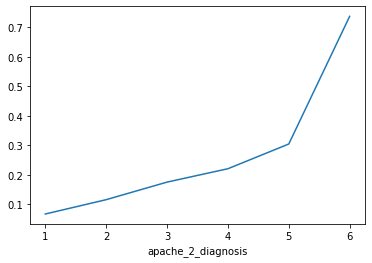

In [ ]:
df_ap_rat = df_diabetes[['apache_2_diagnosis','gender','diabetes_mellitus']].groupby('apache_2_diagnosis').agg({'gender' : 'count', 'diabetes_mellitus' : 'sum'})
df_ap_rat['ratio'] = df_ap_rat['diabetes_mellitus']/df_ap_rat['gender']
df_ap_rat['ratio'].plot()

## mapping icu type column

In [ ]:
def map_categorial(col_name):
    g = df_diabetes.groupby([col_name]).agg(pct_diabetes=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: 100*(x.sum() / len(x))),
                                             num_of_patients=pd.NamedAgg(column="diabetes_mellitus", aggfunc=lambda x: len(x))).copy()
    g.sort_values(by='pct_diabetes', inplace=True)
    map_dic = dict(zip(g.index, list(range(1, len(g)+1))))
    df_diabetes[col_name] = df_diabetes[col_name].map(map_dic)

In [ ]:
map_categorial('icu_type')

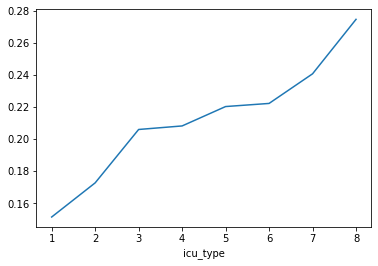

In [ ]:
df_ap_rat = df_diabetes[['icu_type','gender','diabetes_mellitus']].groupby('icu_type').agg({'gender' : 'count', 'diabetes_mellitus' : 'sum'})
df_ap_rat['ratio'] = df_ap_rat['diabetes_mellitus']/df_ap_rat['gender']
df_ap_rat['ratio'].plot()

## mapping ethnicity column

In [ ]:
map_categorial('ethnicity')

In [ ]:
df_diabetes_trees = df_diabetes.copy()

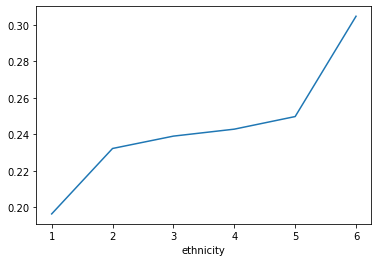

In [ ]:
df_ap_rat = df_diabetes[['ethnicity','gender','diabetes_mellitus']].groupby('ethnicity').agg({'gender' : 'count', 'diabetes_mellitus' : 'sum'})
df_ap_rat['ratio'] = df_ap_rat['diabetes_mellitus']/df_ap_rat['gender']
df_ap_rat['ratio'].plot()

## creating age X age_group X gender columns

In [ ]:
def set_age_group(age):
  if age <= 35:
    return '<35'
  elif age <= 75:
    return '35<age<75'
  else:
    return '>75'

In [ ]:
# split to age groups
df_diabetes['age_group'] = df_diabetes['age'].apply(lambda age : set_age_group(age))

In [ ]:
# split gender and age groups to dummies
df_diabetes = pd.get_dummies(data = df_diabetes, columns = ['gender', 'age_group'])


In [ ]:
# set ageXgenderXage_group columns
gender = ['gender_F',	'gender_M']
age_g = ['age_group_35<age<75','age_group_<35','age_group_>75']

for gend in gender:
  for ageg in age_g:
    df_diabetes[gend + 'X' + ageg] = df_diabetes[gend] * df_diabetes[ageg] * df_diabetes['age']

df_diabetes.drop(columns = ['age_group_35<age<75','age_group_<35','age_group_>75', 'age'], inplace = True)


## check for other columns that should be splitted

In [ ]:
# sns.pairplot(data=df_diabetes.drop(
#                                     columns = ['gender_FXage_group_35<age<75',	'gender_FXage_group_<35',	'gender_FXage_group_>75',
#                                               'gender_MXage_group_35<age<75',	'gender_MXage_group_<35',	'gender_MXage_group_>75']),
#                                     hue = "diabetes_mellitus")

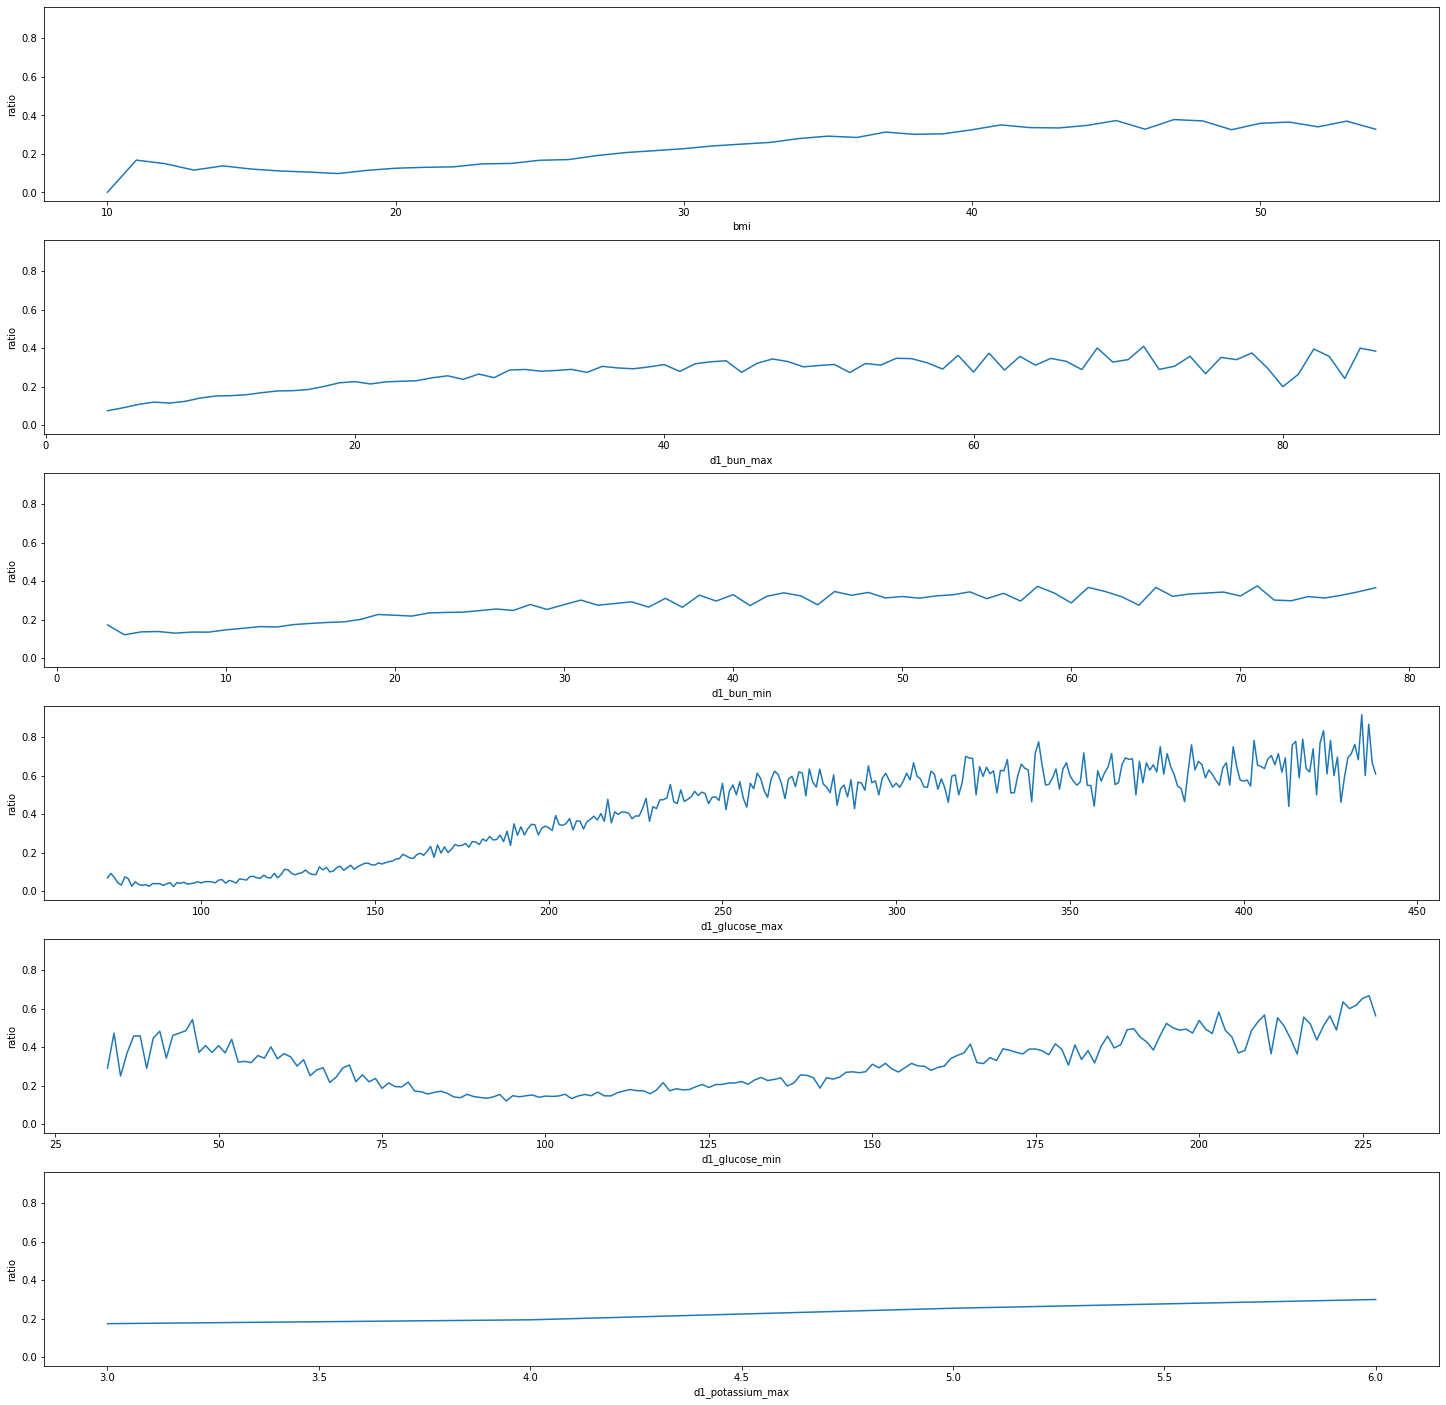

In [ ]:
df_cols = df_diabetes.drop(columns = ['gender_FXage_group_35<age<75',	'gender_FXage_group_<35',	'gender_FXage_group_>75',
                                      'gender_MXage_group_35<age<75',	'gender_MXage_group_<35',	'gender_MXage_group_>75', 'diabetes_mellitus', 'ethnicity','icu_type', 'apache_2_diagnosis'])

fig, axes = plt.subplots(6,1, figsize = (25,25), sharey = True)
for ax, col in zip(axes, df_cols):
  df_rat_ = df_diabetes.copy()
  df_rat_[col] = df_rat_[col].apply(lambda x: round(x))
  df_rat_ = df_rat_[[col,'ethnicity','diabetes_mellitus']].groupby(col).agg({'ethnicity' : 'count', 'diabetes_mellitus' : 'sum'})
  df_rat_['ratio'] = df_rat_['diabetes_mellitus']/df_rat_['ethnicity']
  sns.lineplot(data = df_rat_, y = 'ratio',x = col, ax = ax)
  plt.xlabel(col)


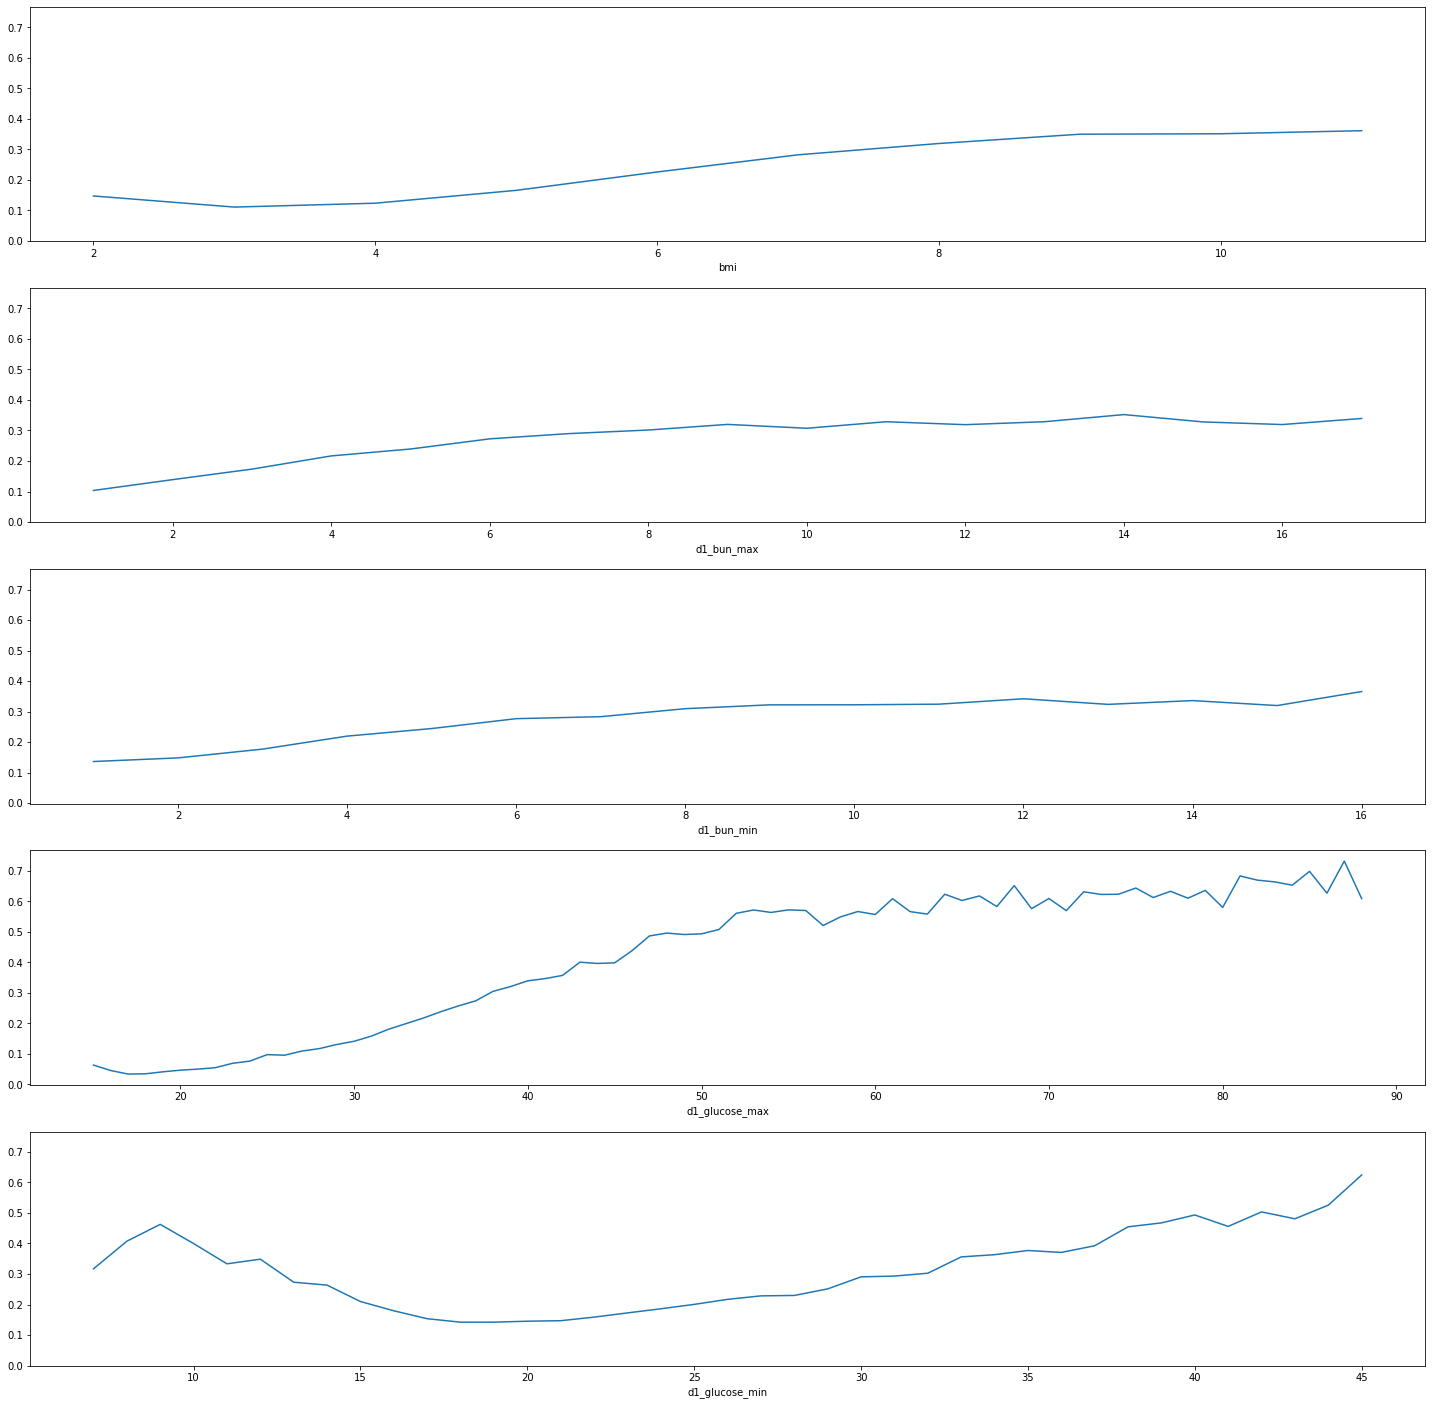

In [ ]:
fig, axes = plt.subplots(5,1, figsize = (25,25), sharey = True)
for ax, col in zip(axes, df_cols.drop(columns = ['d1_potassium_max'])):
  df_rat = df_diabetes.copy()
  df_rat[col] = df_rat[col].apply(lambda x: round(x/5))
  df_rat = df_rat[[col,'ethnicity','diabetes_mellitus']].groupby(col).agg({'ethnicity' : 'count', 'diabetes_mellitus' : 'sum'})
  df_rat['ratio'] = df_rat['diabetes_mellitus']/df_rat['ethnicity']
  df_rat['ratio'].plot(ax = ax)
  plt.xlabel(col)

  

## create glucose_minXglucose_min<95 and glucose_minXglucose_min>95

In [ ]:
def set_glu_group(glu):
  if glu <= 95:
    return '<95'
  else:
    return '>95'

In [ ]:
df_diabetes['glu_group'] = df_diabetes['d1_glucose_min'].apply(lambda glu : set_glu_group(glu))

In [ ]:
# split glu_groups to dummies
df_diabetes = pd.get_dummies(data = df_diabetes, columns = ['glu_group'])


In [ ]:
df_diabetes['d1_glucose_min'].value_counts()

97.0     1585
96.0     1552
100.0    1545
95.0     1540
92.0     1538
         ... 
34.0       36
37.0       35
223.0      35
227.0      32
35.0       32
Name: d1_glucose_min, Length: 195, dtype: int64

In [ ]:
# set 'd1_glucose_minXgenderXglu_group columns
gender = ['gender_F',	'gender_M']
glu_g = ['glu_group_<95','glu_group_>95']

for gend in gender:
  for glug in glu_g:
    df_diabetes[gend + 'X' + glug] = df_diabetes[gend] * df_diabetes[glug] * df_diabetes['d1_glucose_min']

df_diabetes.drop(columns = ['d1_glucose_min', 'glu_group_<95', 'glu_group_>95', 'd1_glucose_min'], inplace = True)


## create , bmiXbmi<18, bmiX18<bmi<65 and bmiXbmi>65

In [ ]:
def set_bmi_group(bmi):
  if bmi <= 18:
    return '<18'
  else:
    return '18>'


In [ ]:
df_diabetes['bmi_group'] = df_diabetes['bmi'].apply(lambda bmi : set_bmi_group(bmi))

In [ ]:
# split bmi_groups to dummies
df_diabetes = pd.get_dummies(data = df_diabetes, columns = ['bmi_group'])
df_diabetes.head()

,bmi,ethnicity,icu_type,apache_2_diagnosis,d1_bun_max,d1_bun_min,d1_glucose_max,d1_potassium_max,diabetes_mellitus,gender_F,...,gender_FXage_group_>75,gender_MXage_group_35<age<75,gender_MXage_group_<35,gender_MXage_group_>75,gender_FXglu_group_<95,gender_FXglu_group_>95,gender_MXglu_group_<95,gender_MXglu_group_>95,bmi_group_18>,bmi_group_<18
0,22.732803,1,7,4.0,31.0,30.0,168.0,4.0,1,0,...,0.0,68.0,0.0,0.0,0.0,0.0,0.0,109.0,1,0
1,27.421875,1,4,4.0,11.0,9.0,145.0,4.2,1,1,...,77.0,0.0,0.0,0.0,0.0,128.0,0.0,0.0,1,0
5,27.555611,1,4,3.0,13.0,13.0,156.0,3.9,1,0,...,0.0,67.0,0.0,0.0,0.0,0.0,0.0,125.0,1,0
9,25.707702,2,6,4.0,10.0,10.0,134.0,4.1,0,0,...,0.0,50.0,0.0,0.0,0.0,0.0,0.0,134.0,1,0
10,28.257052,4,4,3.0,14.0,14.0,158.0,4.2,0,1,...,0.0,0.0,0.0,0.0,0.0,133.0,0.0,0.0,1,0


In [ ]:
# set glu_groupsXd1_glucose_min columns
gender = ['gender_F',	'gender_M']
bmi_g = ['bmi_group_18>',	'bmi_group_<18']

for gend in gender:
  for bmi in bmi_g:
    df_diabetes[gend + 'X' + bmi] = df_diabetes[gend] * df_diabetes[bmi] * df_diabetes['bmi']

df_diabetes.drop(columns = ['bmi_group_18>', 'bmi_group_<18', 'bmi'], inplace = True)


In [ ]:
df_diabetes.head()

,ethnicity,icu_type,apache_2_diagnosis,d1_bun_max,d1_bun_min,d1_glucose_max,d1_potassium_max,diabetes_mellitus,gender_F,gender_M,...,gender_MXage_group_<35,gender_MXage_group_>75,gender_FXglu_group_<95,gender_FXglu_group_>95,gender_MXglu_group_<95,gender_MXglu_group_>95,gender_FXbmi_group_18>,gender_FXbmi_group_<18,gender_MXbmi_group_18>,gender_MXbmi_group_<18
0,1,7,4.0,31.0,30.0,168.0,4.0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,109.0,0.000000,0.0,22.732803,0.0
1,1,4,4.0,11.0,9.0,145.0,4.2,1,1,0,...,0.0,0.0,0.0,128.0,0.0,0.0,27.421875,0.0,0.000000,0.0
5,1,4,3.0,13.0,13.0,156.0,3.9,1,0,1,...,0.0,0.0,0.0,0.0,0.0,125.0,0.000000,0.0,27.555611,0.0
9,2,6,4.0,10.0,10.0,134.0,4.1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,134.0,0.000000,0.0,25.707702,0.0
10,4,4,3.0,14.0,14.0,158.0,4.2,0,1,0,...,0.0,0.0,0.0,133.0,0.0,0.0,28.257052,0.0,0.000000,0.0


In [ ]:
df_diabetes[df_diabetes.columns].drop(columns = ['gender_F',	'gender_M'])

,ethnicity,icu_type,apache_2_diagnosis,d1_bun_max,d1_bun_min,d1_glucose_max,d1_potassium_max,diabetes_mellitus,gender_FXage_group_35<age<75,gender_FXage_group_<35,...,gender_MXage_group_<35,gender_MXage_group_>75,gender_FXglu_group_<95,gender_FXglu_group_>95,gender_MXglu_group_<95,gender_MXglu_group_>95,gender_FXbmi_group_18>,gender_FXbmi_group_<18,gender_MXbmi_group_18>,gender_MXbmi_group_<18
0,1,7,4.0,31.0,30.0,168.0,4.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,109.0,0.000000,0.0,22.732803,0.0
1,1,4,4.0,11.0,9.0,145.0,4.2,1,0.0,0.0,...,0.0,0.0,0.0,128.0,0.0,0.0,27.421875,0.0,0.000000,0.0
5,1,4,3.0,13.0,13.0,156.0,3.9,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,125.0,0.000000,0.0,27.555611,0.0
9,2,6,4.0,10.0,10.0,134.0,4.1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,134.0,0.000000,0.0,25.707702,0.0
10,4,4,3.0,14.0,14.0,158.0,4.2,0,72.0,0.0,...,0.0,0.0,0.0,133.0,0.0,0.0,28.257052,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130151,5,7,4.0,8.0,7.0,182.0,5.1,0,50.0,0.0,...,0.0,0.0,0.0,121.0,0.0,0.0,20.324301,0.0,0.000000,0.0
130153,1,5,3.0,32.0,32.0,139.0,3.6,0,0.0,0.0,...,0.0,0.0,0.0,139.0,0.0,0.0,29.653433,0.0,0.000000,0.0
130154,5,3,4.0,31.0,30.0,346.0,4.4,1,0.0,0.0,...,0.0,0.0,0.0,0.0,55.0,0.0,0.000000,0.0,32.265371,0.0
130155,1,4,3.0,45.0,45.0,156.0,5.7,0,0.0,0.0,...,0.0,81.0,0.0,0.0,0.0,137.0,0.000000,0.0,24.408579,0.0


In [ ]:
df_diabetes = pd.DataFrame(MinMaxScaler().fit_transform(df_diabetes), columns = df_diabetes.columns)

# fit models

In [ ]:
def cross_val(clf, clf_model_name):
    scores = cross_val_score(clf, X_train, y_train, cv=sss, scoring='roc_auc')
    print("Scores ",clf_model_name,": " + (k * "{:.3f} ").format(*scores))

In [ ]:
def plot_auc(clf, clf_model_name):
    scores_auc = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, scores_auc, pos_label=1)
    res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
    auc_score = round(roc_auc_score(y_test==1, scores_auc), 3)
    plt.plot(fpr, tpr, 'k--',linewidth=2)
    plt.fill_between(fpr, tpr, color='lightskyblue')
    plt.title(f'ROC of {clf_model_name}')
    plt.text(0.5, 0.5, f'AUC {auc_score}', size=15)
    plt.xlabel('FPR (False Positive Rate = 1-specificity)')
    plt.ylabel('TPR (True Positive Rate = sensitivity)')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

In [ ]:
k = 3
sss = StratifiedShuffleSplit(n_splits=k, test_size=0.2, random_state=0)

## logistic regression 

In [ ]:
df_diabetes.head()

,ethnicity,icu_type,apache_2_diagnosis,d1_bun_max,d1_bun_min,d1_glucose_max,d1_potassium_max,diabetes_mellitus,gender_F,gender_M,...,gender_MXage_group_<35,gender_MXage_group_>75,gender_FXglu_group_<95,gender_FXglu_group_>95,gender_MXglu_group_<95,gender_MXglu_group_>95,gender_FXbmi_group_18>,gender_FXbmi_group_<18,gender_MXbmi_group_18>,gender_MXbmi_group_<18
0,0.0,0.857143,0.6,0.329268,0.357616,0.260274,0.346821,1.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.480176,0.000000,0.0,0.422286,0.0
1,0.0,0.428571,0.6,0.085366,0.079470,0.197260,0.404624,1.0,1.0,0.0,...,0.0,0.0,0.0,0.563877,0.0,0.000000,0.509487,0.0,0.000000,0.0
2,0.0,0.428571,0.4,0.109756,0.132450,0.227397,0.317919,1.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.550661,0.000000,0.0,0.511874,0.0
3,0.2,0.714286,0.6,0.073171,0.092715,0.167123,0.375723,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,0.590308,0.000000,0.0,0.477548,0.0
4,0.6,0.428571,0.4,0.121951,0.145695,0.232877,0.404624,0.0,1.0,0.0,...,0.0,0.0,0.0,0.585903,0.0,0.000000,0.525005,0.0,0.000000,0.0


In [ ]:
X = df_diabetes.drop('diabetes_mellitus', axis=1)
y = df_diabetes.diabetes_mellitus

In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, test_size=0.3, 
                     random_state=7109179, shuffle=True, stratify=y)

In [ ]:
lr = LogisticRegression()

In [ ]:
param_grid = {'C': [1, 10, 100, 1000], 'class_weight' : [{0: 4, 1: 1}, {0: 1, 1: 1}]}

In [ ]:
gs = GridSearchCV(lr, param_grid, cv=sss, scoring='roc_auc')
gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.2,
            train_size=None),
             estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100, 1000],
                         'class_weight': [{0: 4, 1: 1}, {0: 1, 1: 1}]},
             scoring='roc_auc')

In [ ]:
print(gs.best_params_)

{'C': 10, 'class_weight': {0: 1, 1: 1}}


In [ ]:
gs_lr = LogisticRegression(C = 10)
scores = cross_val_score(gs_lr, X_train, y_train, cv=7, scoring='roc_auc')
print(scores)

[0.82261871 0.82255305 0.813061   0.8188917  0.81305236 0.82545638
 0.82619874]


Scores  LogisticRegression : 0.823 0.828 0.814 


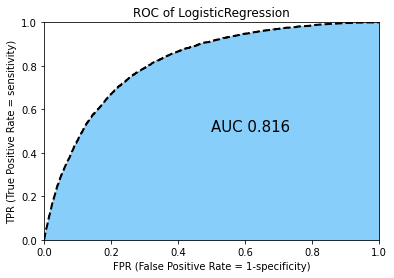

In [ ]:
lr = LogisticRegression(C = 10)
lr.fit(X_train, y_train)
cross_val(lr, 'LogisticRegression')
plot_auc(lr, 'LogisticRegression')

## Decision Tree 

In [ ]:
df_diabetes_trees = pd.get_dummies(df_diabetes_trees, columns = ['gender'])
df_diabetes_trees

,age,bmi,ethnicity,icu_type,apache_2_diagnosis,d1_bun_max,d1_bun_min,d1_glucose_max,d1_glucose_min,d1_potassium_max,diabetes_mellitus,gender_F,gender_M
0,68.0,22.732803,1,7,4.0,31.0,30.0,168.0,109.0,4.0,1,0,1
1,77.0,27.421875,1,4,4.0,11.0,9.0,145.0,128.0,4.2,1,1,0
5,67.0,27.555611,1,4,3.0,13.0,13.0,156.0,125.0,3.9,1,0,1
9,50.0,25.707702,2,6,4.0,10.0,10.0,134.0,134.0,4.1,0,0,1
10,72.0,28.257052,4,4,3.0,14.0,14.0,158.0,133.0,4.2,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130151,50.0,20.324301,5,7,4.0,8.0,7.0,182.0,121.0,5.1,0,1,0
130153,79.0,29.653433,1,5,3.0,32.0,32.0,139.0,139.0,3.6,0,1,0
130154,73.0,32.265371,5,3,4.0,31.0,30.0,346.0,55.0,4.4,1,0,1
130155,81.0,24.408579,1,4,3.0,45.0,45.0,156.0,137.0,5.7,0,0,1


In [ ]:
# df_diabetes_trees = pd.DataFrame(MinMaxScaler().fit_transform(df_diabetes_trees), columns = df_diabetes_trees.columns)
# df_diabetes_trees.head()

In [ ]:
X = df_diabetes_trees.drop(columns = ['diabetes_mellitus'])
y = df_diabetes_trees['diabetes_mellitus']

pca_d1_bun = PCA(n_components=1).fit(X[['d1_bun_max',	'd1_bun_min']].copy())
print(f'd1_bun pca variance: {pca_d1_bun.explained_variance_ratio_.cumsum()}')

pca_d1_glucose = PCA(n_components=1).fit(X[['d1_glucose_max',	'd1_glucose_min']].copy())
print(f'd1_glucose pca variance: {pca_d1_bun.explained_variance_ratio_.cumsum()}')

d1_bun pca variance: [0.98526777]
d1_glucose pca variance: [0.98526777]


In [ ]:
X_pca_d1_bun = PCA(n_components=1).fit_transform(X[['d1_bun_max',	'd1_bun_min']])
X_pca_d1_glucose = PCA(n_components=1).fit_transform(X[['d1_glucose_max',	'd1_glucose_min']])

X['pca_d1_bun'] = X_pca_d1_bun
X['pca_d1_glucose'] = X_pca_d1_glucose

X.drop(columns = ['d1_bun_max',	'd1_bun_min', 'd1_glucose_max',	'd1_glucose_min'], inplace = True)

In [ ]:
X.head()

,age,bmi,ethnicity,icu_type,apache_2_diagnosis,d1_potassium_max,gender_F,gender_M,pca_d1_bun,pca_d1_glucose
0,68.0,22.732803,1,7,4.0,4.0,0,1,12.558587,3.537039
1,77.0,27.421875,1,4,4.0,4.2,1,0,-16.392504,-14.977573
5,67.0,27.555611,1,4,3.0,3.9,0,1,-12.199923,-4.848944
9,50.0,25.707702,2,6,4.0,4.1,0,1,-16.440155,-24.478394
10,72.0,28.257052,4,4,3.0,4.2,1,0,-10.786513,-1.219071


In [ ]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.7, test_size=0.3, 
                     random_state=111, shuffle=True, stratify=y)

In [ ]:
# grid search
my_param_grid = {'criterion':['gini', 'entropy'], 'max_depth':[10, 15, 20], 'min_samples_split' : [2, 5, 10, 100],  'class_weight' : [{0: 4, 1: 1}, {0: 1, 1: 1}]}
dt = DecisionTreeClassifier()
dt_gs = GridSearchCV(dt, my_param_grid, cv=sss)
dt_gs.fit(X_train, y_train)
print("Best parameters:", dt_gs.best_params_)

Best parameters: {'class_weight': {0: 1, 1: 1}, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 100}


Scores  DecisionTreeClassifier : 0.793 0.791 0.794 


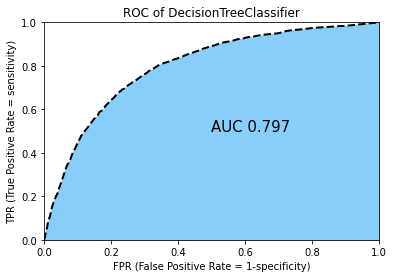

In [ ]:
DecisionTree = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=100)
DecisionTree.fit(X_train, y_train)
cross_val(DecisionTree, 'DecisionTreeClassifier')
plot_auc(DecisionTree, 'DecisionTreeClassifier')

## random forest

In [ ]:
# grid search
my_param_grid = {'n_estimators':[50, 100, 150], 'criterion':['gini', 'entropy'], 'max_depth':[10, 15, 20]}
rf = RandomForestClassifier(random_state=4)
rf_gs = GridSearchCV(rf, my_param_grid, cv=sss)
rf_gs .fit(X_train, y_train)
print("Best parameters:", rf_gs.best_params_)

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 150}


Scores  RandomForest : 0.820 0.814 0.818 


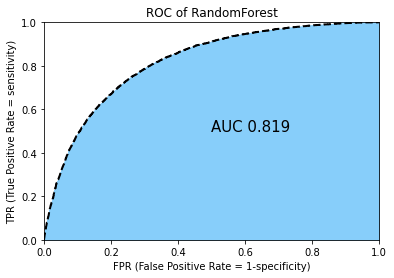

In [ ]:
RandomForest = RandomForestClassifier(criterion = 'entropy', max_depth = 10, n_estimators = 150)
RandomForest.fit(X_train, y_train)
cross_val(RandomForest, 'RandomForest')
plot_auc(RandomForest, 'RandomForest')

Scores  RandomForest : 0.821 0.814 0.818 


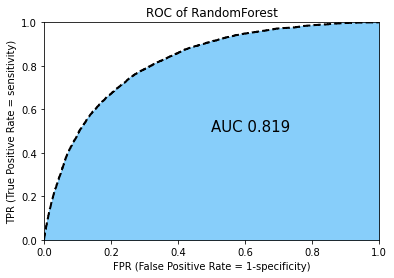

In [ ]:
RandomForest = RandomForestClassifier(criterion = 'gini', max_depth = 10, n_estimators = 150)
RandomForest.fit(X_train, y_train)
cross_val(RandomForest, 'RandomForest')
plot_auc(RandomForest, 'RandomForest')

## Bagging of Random Forest

In [ ]:
RandomForest_bagging = BaggingClassifier(base_estimator=RandomForest)
RandomForest_bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=10,
                                                        n_estimators=150))

Scores  BaggingRandomForest : 0.821 0.815 0.819 


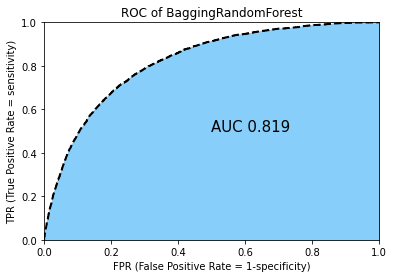

In [ ]:
cross_val(RandomForest_bagging, 'BaggingRandomForest')
plot_auc(RandomForest_bagging, 'BaggingRandomForest')

## Ada boost

In [ ]:
# gread search
my_param_grid = {'n_estimators':[100, 150, 200, 250], 'learning_rate':[0.005, 0.01, 0.015]}
clf_adaboost = AdaBoostClassifier(base_estimator = DecisionTree)
clf_gs = GridSearchCV(clf_adaboost, my_param_grid, cv=sss)
clf_gs.fit(X_train, y_train)
print("Best parameters:", clf_gs.best_params_)

Scores  Ada boost : 0.790 0.786 0.794 


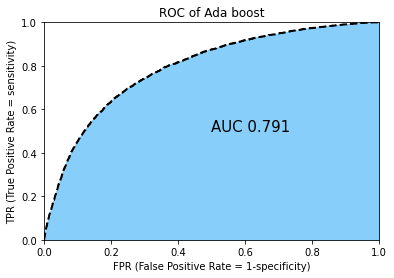

In [ ]:
clf = AdaBoostClassifier(base_estimator= DecisionTree, learning_rate=0.015, n_estimators=250)
clf.fit(X_train, y_train)
cross_val(clf, 'Ada boost')
plot_auc(clf, 'Ada boost')

## XGBoost

In [ ]:
my_param_grid = {'n_estimators':[100, 150, 200], 'learning_rate':[0.005, 0.01], 'max_depth':[10, 15], 'eval_metric':['auc']}
xg = XGBClassifier()
xg_gs = GridSearchCV(xg, my_param_grid, cv=sss)
xg_gs.fit(X_train, y_train)
print("Best parameters:", xg_gs.best_params_)

Best parameters: {'eval_metric': 'auc', 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 150}


Scores  XGBClassifier : 0.814 0.810 0.816 


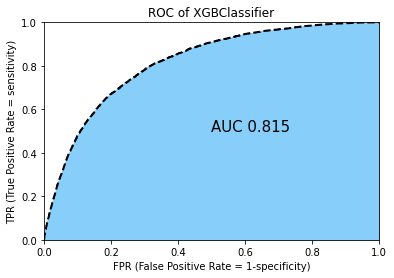

In [ ]:
XG = XGBClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, eval_metric='auc')
XG.fit(X_train, y_train)
cross_val(XG, 'XGBClassifier')
plot_auc(XG, 'XGBClassifier')

## LightGBM

In [ ]:
# gread search
my_param_grid = {'n_estimators':[100, 150, 200], 'learning_rate':[0.005, 0.01], 'max_depth':[10, 15], 'metric':['auc']}
lgbm = LGBMClassifier()
lgbm_gs = GridSearchCV(lgbm, my_param_grid, cv=sss)
lgbm_gs.fit(X_train, y_train)
print("Best parameters:", lgbm_gs.best_params_)

Best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'metric': 'auc', 'n_estimators': 200}


Scores  LGBMClassifier : 0.818 0.812 0.819 


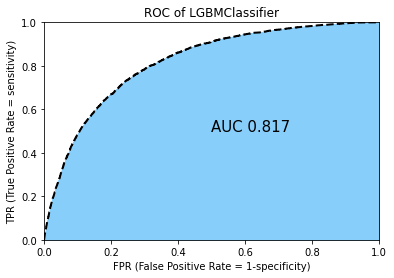

In [ ]:
LGBM = LGBMClassifier(max_depth=10, learning_rate=0.01, n_estimators=200, metric='auc')
LGBM.fit(X_train, y_train)
cross_val(LGBM, 'LGBMClassifier')
plot_auc(LGBM, 'LGBMClassifier')

## voting

In [ ]:
classifiers = [('random forest', RandomForest), ('XGB', XG), ('LGBM', LGBM)]
clf_voting = VotingClassifier(estimators=classifiers, voting='soft')
clf_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('random forest',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=150)),
                             ('XGB',
                              XGBClassifier(eval_metric='auc',
                                            learning_rate=0.01, max_depth=10,
                                            n_estimators=200)),
                             ('LGBM',
                              LGBMClassifier(learning_rate=0.01, max_depth=10,
                                             metric='auc', n_estimators=200))],
                 voting='soft')

Scores  Voting : 0.820 0.814 0.820 


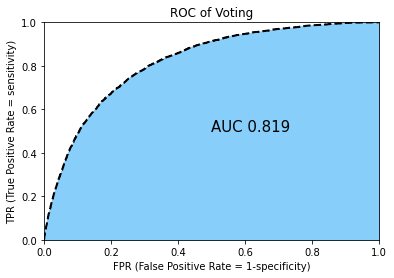

In [ ]:
cross_val(clf_voting, 'Voting')
plot_auc(clf_voting, 'Voting')

# diabetes mellitus

* **goal -** 

  Getting a rapid understanding of the context of a patient’s overall health has been particularly important during the COVID-19 pandemic as healthcare workers around the world struggle with hospitals overloaded by patients in critical condition. Intensive Care Units (ICUs) often lack verified medical histories for incoming patients. A patient in distress or a patient who is brought in confused or unresponsive may not be able to provide information about chronic conditions such as heart disease, injuries, or diabetes. Medical records may take days to transfer, especially for a patient from another medical provider or system.

  Knowledge about chronic conditions such as diabetes can inform clinical decisions about patient care and ultimately improve patient outcomes.

* **background -**

  Diabetes mellitus is a disorder in which the amount of sugar in the blood is elevated. there are 2 main types of diabetes
  - Type 1 diabetes:
(formerly called insulin-dependent diabetes or juvenile-onset diabetes), the body's immune system attacks the insulin-producing cells of the pancreas, and more than 90% of them are permanently destroyed.

  - Type 2 diabetes: (formerly called non–insulin-dependent diabetes or adult-onset diabetes), the pancreas often continues to produce insulin, sometimes even at higher-than-normal levels, especially early in the disease. However, the body develops resistance to the effects of insulin, so there is not enough insulin to meet the body’s needs. As type 2 diabetes progresses, the insulin-producing ability of the pancreas decreases.

  - measurements which may connect to diabetes:

    - high blood glucouse
    - glycolated hemoglobin 
    - over 45 years old
    - overweight or obese
    -  high blood pressure and/or a lipid disorder such as high cholesterol
    - African American, Hispanic, Asian American, or American Indian ethnicity










